In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Prepare the dataset

In [4]:
block_size = 3

In [5]:
# Prepare a dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        #print(w)
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join([itos[i] for i in context]) + ' --> ' + ch)
            context = context[1:] + [idx]
        #print('')

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
words[:5]
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(f"Train dataset shape: ({Xtr.shape, Ytr.shape})")
print(f"Dev dataset shape: ({Xdev.shape, Ydev.shape})")
print(f"Test dataset shape: ({Xte.shape, Yte.shape})")

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64
Train dataset shape: ((torch.Size([182625, 3]), torch.Size([182625])))
Dev dataset shape: ((torch.Size([22655, 3]), torch.Size([22655])))
Test dataset shape: ((torch.Size([22866, 3]), torch.Size([22866])))


### Scratch space for learning

In [7]:
#initialize a Look up table
C = torch.randn((27,2))

In [8]:
# embeddings for all the inputs
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

In [9]:
# Concatenate the embeddings of all 3 chars in the inputs and reduce the middle dim
# torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]),dim=1)
# Below line is equivalent to the above line. Unbind does exactly teh slicing that is done manually in 
# the above line
torch.cat(torch.unbind(emb, dim=1),dim=1).shape

torch.Size([182625, 6])

In [10]:
# More efficient way to do teh above tensor manipulation is using .view as below
emb.view(-1,6).shape

torch.Size([182625, 6])

In [11]:
# Weights and biases
W = torch.randn((6, 100)) # 100 is hyperparameter. It's number of activations
b = torch.randn(100)

### Neural network training code

In [12]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [13]:
# parameters
embedding_dim = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_dim), generator=g)  # Look up table for embedding of each character
W1 = torch.randn((embedding_dim * block_size, 200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2]

In [14]:
sum([p.nelement() for p in parameters]) # total parameters

11897

In [15]:
# Set requires grad to true
for p in parameters:
    p.requires_grad = True

In [16]:
stepi = []
lossi = []

In [17]:
# Gradient descent
for i in range(200000):
    # construct a minibatch
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # Forward pass
    emb = C[Xtr[ix]].view(-1, embedding_dim * block_size) # [batch_size, embedding_dim * block_size] Ex: [32, 6]
    h1 = torch.tanh(emb @ W1 + b1) # [32, 6] @ [6, 100] + [100,] --> [32, 100] + [100] --> [32,100] (Using broadcasting rules)
    logits = h1 @ W2 + b2 # [32, 100] @ [100, 27] + [27] --> [32, 27] + [27] --> [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix]) # [1,]

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # set this to 0.1 in the beginning and decay later
    for p in parameters:
        p.data += -lr * p.grad
    
    # track values
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    #print(f"iter={i}, loss={loss}")


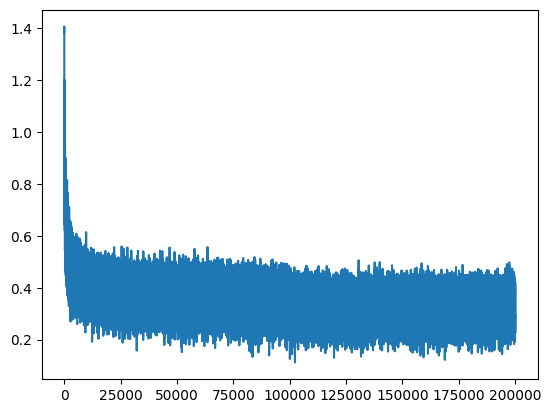

In [18]:
# Plot teh loss curve
plt.plot(stepi, lossi)

In [19]:
# Evaluate the loss on the entire training set
def calculate_loss(X, Y):
    emb = C[X].view(-1, embedding_dim * block_size)
    h1 = torch.tanh(emb @ W1 + b1)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    loss
    return loss

In [20]:
# Train loss
train_loss = calculate_loss(Xtr, Ytr)
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Train loss={train_loss}, dev loss={dev_loss}")

Train loss=2.1218340396881104, dev loss=2.159954071044922


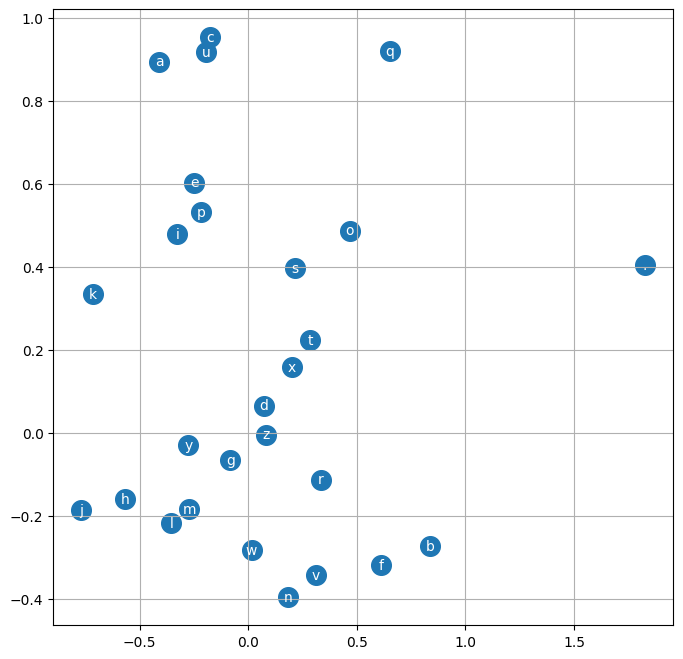

In [21]:
# Visualize the embeddings
# Makes sense only if the embedding_dim is set to 2.
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [22]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647)
for j in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor(context)].view(-1, embedding_dim * block_size)
        h1 = torch.tanh(emb @ W1 + b1)
        logits = h1 @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, 1, replacement=True, generator=g).item()
        ch = itos[idx]
        #print(ch)
        context = context[1:] + [idx]
        out += [idx]
        if idx == 0: # end of word
            break
    print(''.join([itos[i] for i in out]))

mir.
avtarikarlynsley.
kimbrely.
elandlynnu.
rigan.
ciio.
hakaishalanifentley.
elyn.
raj.
avaaganur.
hellagolin.
deolu.
aiba.
amilie.
aaustobica.
ross.
dye.
vesrie.
lannykayson.
deonalaylina.


In [23]:
context = [0] * block_size
context_ = torch.tensor(context)
C.shape
print(C[context_].shape)

torch.Size([3, 10])


In [24]:
W1.shape

torch.Size([30, 200])